# 불량품 예측

불량품을 예측하기 위해 다음과 같은 함수화 정리를 진행한다. 혼란을 막기 위해 모든 과정을 함수화 하기로 한다.  
목차는 다음과 같다.

- 1. Load packages & Data
- 2. Function

## 1. Load Packages & Data

In [1]:
### ide packages
import os
from pprint import pprint
import numpy as np
import pandas as pd
import random
import string
from tqdm import tqdm

# sklearn preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    precision_recall_curve,
    recall_score,
)

# models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_metric
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.cluster import KMeans

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# tuning
import optuna

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
load_dir = './data/'
train = pd.read_csv(load_dir + "train.csv")
test = pd.read_csv(load_dir + "test.csv")

## 2. Functions

In [3]:
# 평가 스코어 지정하기
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

# 평가 매트릭 계산 결과 보여주기
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 해당 공정 맞춤형 위치 옮기기
def move_data(data):
    # divide
    dam = data.filter(regex='_Dam')
    fill1 = data.filter(regex='_Fill1')
    fill2 = data.filter(regex='_Fill2')
    autoclave = data.filter(regex='_AutoClave')
    target = data['target']

    # dam
    dam = dam.dropna(axis=1, how='all')
    dam = dam.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
    dam_mask = dam[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
    dam = dam.drop(columns='WorkMode Collect Result_Dam')

    # fill1
    fill1 = fill1.dropna(axis=1, how='all')
    fill1 = fill1.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
    fill1_mask = fill1[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
    fill1.loc[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1.columns[14:]] = fill1_mask
    fill1 = fill1.drop(columns='WorkMode Collect Result_Fill1')

    # fill2
    fill2 = fill2.dropna(axis=1, how='all')
    fill2 = fill2.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
    fill2_mask = fill2[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
    fill2 = fill2.drop(columns='WorkMode Collect Result_Fill2')

    # CONCAT
    data = pd.concat([dam, fill1, fill2, autoclave, target], axis=1)
    
    return data

In [5]:
# 칼럼 위치 변경
def swap_columns(df, condition, col1, col2):
    # 조건에 해당하는 행 필터링
    filtered_df = df[condition]
    
    # 값 교환
    df.loc[condition, [col1, col2]] = filtered_df[[col1, col2]].copy().iloc[:, ::-1].values

    return df

In [6]:
# Equipment 방향 통일과 잘못된 위치 재조정하기
def change_data(train, test):
    # train
    train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    X_sum_down_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_down_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    X_sum_up_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_up_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    X_sum_down = (X_sum_down_1 - X_sum_down_2) / 2 # stage1에서 빼고, Stage3에서 더하기 <500
    X_sum_up = (X_sum_up_2 - X_sum_up_1) / 2 # stage1에서 더하고, Stage 3에서 빼기

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # test
    test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # train
    Y_sum_dam_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']

    Y_sum_dam_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']

    Y_sum_dam_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']

    Y_sum_fill_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']

    Y_sum_fill_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    Y_sum_fill_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']

    # test
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')


    ### Test
    # 조건을 만족하는 행 인덱스를 찾음
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')
    
    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')
    
    ### Train
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    return train, test

In [7]:
# Dam, Fill1, Fill2에서 지정된 값이 다를 경우 Abnormal 
def inconsistant(data, columnname, iwantthiscolumnsname, is_train = True):
    # 장비 번호가 다르면 불일치
    if is_train:
        cri = [
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill1'],
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill2'],
            df_train[columnname + '_Fill1'] != df_train[columnname + '_Fill2'],
            data[iwantthiscolumnsname] == 1
        ]
        
    else:
        cri = [
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill1'],
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill2'],
            df_test[columnname + '_Fill1'] != df_test[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
    con = [1, 1, 1, 1]

    data[iwantthiscolumnsname] = np.select(cri, con, default = 0)

In [8]:
# 변수 세팅
def variable_setting(types, tr, te, columns_to_convert, columns_to):
    train = tr.copy()
    test = te.copy()
    
    if types == 'catboost':
        dtype = 'string'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'lightgbm':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'xgboost':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    return train, test

In [9]:
def model_best_threshold(model, X_valid, y_valid):
    # Precision - Recall
    y_pred_proba = model.predict_proba(X_valid)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
    f1_scores = 2*recall*precision / (recall + precision)
    cat_best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
    
    return thresholds, y_pred_custom_threshold

In [10]:
def xgboost_optuna(train, cat_features_indices):
    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        }

        model = xgb.XGBClassifier(eval_metric='logloss', **params)

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

In [11]:
def lightgbm_optuna(train, cat_features_indices):

    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    def objective(trial):
        lgbm_params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 1500),
            "max_depth": trial.suggest_int('max_depth', 3, 63),
            "learning_rate": trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True), 
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            "min_child_weight": trial.suggest_float('min_child_weight', 0.5, 4),
            "min_child_samples": trial.suggest_int('min_child_samples', 5, 100),
            "subsample": trial.suggest_float('subsample', 0.4, 1),
            "subsample_freq": trial.suggest_int('subsample_freq', 0, 5),
            "colsample_bytree": trial.suggest_float('colsample_bytree', 0.2, 1),
            'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        }

        model = LGBMClassifier(**lgbm_params, device='cpu', random_state=42, verbose=-1)

        # 범주형 피처 적용
        model.fit(X_train, y_train, categorical_feature=cat_features_indices)

        # 검증 데이터에서 예측 수행
        y_pred = model.predict(X_valid)

        # F1 점수 계산
        f1 = f1_score(y_valid, y_pred)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

In [12]:
def catboost_optuna(train, cat_features_indices):
    
    # train X, y
    X = train.drop(columns=['target'])
    y = train['target']

    # $plit 
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pooling
    train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)
    
    # tuning parameters
    def objective(trial):
        # 하이퍼파라미터를 샘플링
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            "od_wait": trial.suggest_int("od_wait", 10, 50),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#             "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
            "verbose": 0,
            "random_seed": 42
        }

        # CatBoost 모델 학습
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)

        # 검증 세트에 대한 예측 및 평가
        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=12)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

## 3. Setting

In [13]:
# 기준
columnname = ['Equipment', 'Receip No Collect Result', 'Production Qty Collect Result', 'PalletID Collect Result', ]

In [14]:
# drop oolumns
drop_col = [
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam', 
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam', 
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    
    # Dam, Fill2의 경우 Z값이 서로 같다. -> 그렇다면 Fill1은 높이값에서 흔들린 경우가 있다는 것을 의미한다.
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
    
    # 의미를 찾을 수 없는 컬럼들 제거
    'Wip Line_Fill1', 
    'Process Desc._Fill1', 
    'Insp. Seq No._Fill1', 
    'Insp Judge Code_Fill1', 
    'Equipment_AutoClave',
    'Process Desc._AutoClave', 
    'Wip Line_AutoClave', 
    'Insp Judge Code_AutoClave',
    'Insp. Seq No._AutoClave',
    '1st Pressure Judge Value_AutoClave', 
    '2nd Pressure Judge Value_AutoClave', 
    '3rd Pressure Judge Value_AutoClave', 
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
    'Wip Line_Fill2', 
    'Process Desc._Fill2', 
    'Insp. Seq No._Fill2', 
    'Insp Judge Code_Fill2', 
    'Wip Line_Dam', 
    'Process Desc._Dam', 
    'Insp. Seq No._Dam', 
    'Insp Judge Code_Dam',
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE STANDBY POSITION X Collect Result_Dam',
    'CURE STANDBY POSITION Z Collect Result_Dam',
    'CURE STANDBY POSITION Θ Collect Result_Dam',
    
    # Fill2는 레진을 살포하지 않는다. UV만 진행하는 과정이므로 싹 삭제해 준다.          
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    'HEAD Standby Position X Collect Result_Fill2',
    'HEAD Standby Position Y Collect Result_Fill2',
    'HEAD Standby Position Z Collect Result_Fill2',
    'Head Clean Position X Collect Result_Fill2',
    'Head Clean Position Y Collect Result_Fill2',
    'Head Clean Position Z Collect Result_Fill2',
    'Head Purge Position X Collect Result_Fill2',
    'Head Purge Position Y Collect Result_Fill2',
    'Head Purge Position Z Collect Result_Fill2',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
    'Dispense Volume(Stage1) Collect Result_Fill2',
    'Dispense Volume(Stage2) Collect Result_Fill2',
    'Dispense Volume(Stage3) Collect Result_Fill2',
    
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam',
    
    # 단일값이 하나인 컬럼들, 의미를 찾고싶다면 주석처리 해야하는 것들
    'CURE START POSITION X Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
    'CURE START POSITION Z Collect Result_Dam', # START POSITION
    'CURE START POSITION Θ Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
    'HEAD Standby Position X Collect Result_Dam',
    'HEAD Standby Position Y Collect Result_Dam',
    'HEAD Standby Position Z Collect Result_Dam',
    'Head Clean Position X Collect Result_Dam',
    'Head Clean Position Y Collect Result_Dam', # 흔들림에 따라 Z
    'Head Purge Position X Collect Result_Dam',
    'Head Purge Position Y Collect Result_Dam',
    'Head Zero Position X Collect Result_Dam',
    'HEAD Standby Position X Collect Result_Fill1',
    'HEAD Standby Position Y Collect Result_Fill1',
    'HEAD Standby Position Z Collect Result_Fill1',
    'Head Clean Position X Collect Result_Fill1',
    'Head Clean Position Y Collect Result_Fill1',
    'Head Clean Position Z Collect Result_Fill1',
    'Head Purge Position X Collect Result_Fill1',
    'Head Purge Position Y Collect Result_Fill1',
    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Θ Collect Result_Fill2',
    'CURE STANDBY POSITION X Collect Result_Fill2',
    'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE STANDBY POSITION Θ Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Θ Collect Result_Fill2',
    
    # AutoClave 의미없어보이는거 제거
    'Chamber Temp. Judge Value_AutoClave',
#     'Chamber Temp. Unit Time_AutoClave',
#     '1st Pressure_AutoClave',
#     '1st Pressure 1st Pressure Unit Time_AutoClave',
#     '2nd Pressure_AutoClave',
#     '2nd Pressure Unit Time_AutoClave',
#     '3rd Pressure_AutoClave',
#     '3rd Pressure Unit Time_AutoClave',
    
    # Model.Suffix, Workorder이 같다.
    'Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave',
    'Workorder_Fill1', 'Workorder_Fill2', 'Workorder_AutoClave',
    
    # 아무 의미 없는 값
    'Chamber Temp. Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    
    # 중복 데이터 없애기
    'PalletID Collect Result_Fill1', 
    'Production Qty Collect Result_Fill1',
    'Receip No Collect Result_Fill1',
    'PalletID Collect Result_Fill2', 
    'Production Qty Collect Result_Fill2',
    'Receip No Collect Result_Fill2',
    'Equipment_Fill1',
    'Equipment_Fill2'
]

## 4. Matched Data

In [15]:
# 위치 옮기기
train_move = move_data(train)
test_move = move_data(test)

/tmp/ipykernel_140/691509256.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.     0.012  0.    ...  0.    -0.019  0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
/tmp/ipykernel_140/691509256.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114.612 114.612  85.    ...  85.    114.612  85.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
/tmp/ipykernel_140/691509256.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '

In [16]:
# 위치 변경 및 Equipment2 를 Equipment1 방향으로 변경
df_train, df_test = change_data(train_move, test_move)

### Type Change

In [17]:
# 데이터 타입 변경하기
type_change = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']

for i in type_change:
    df_train[i] = df_train[i].astype('float64')
    df_test[i] = df_test[i].astype('float64')

### Modified Equipment data type

In [18]:
# Equipment 번호만 가져오기
df_train['Equipment_Dam'] = df_train['Equipment_Dam'].str.slice(15, 16)
df_train['Equipment_Fill1'] = df_train['Equipment_Fill1'].str.slice(17, 18)
df_train['Equipment_Fill2'] = df_train['Equipment_Fill2'].str.slice(17, 18)

df_test['Equipment_Dam'] = df_test['Equipment_Dam'].str.slice(15, 16)
df_test['Equipment_Fill1'] = df_test['Equipment_Fill1'].str.slice(17, 18)
df_test['Equipment_Fill2'] = df_test['Equipment_Fill2'].str.slice(17, 18)

### New Column

In [19]:
# 불일치 변수
df_train['inconsistant'] = 0
df_test['inconsistant'] = 0

# 장착
for i in columnname:
    inconsistant(df_train, i, 'inconsistant', True)
    inconsistant(df_test, i, 'inconsistant', False)

In [20]:
# 시간이 0이하, 900이상인 값은 이상치로 분류
for j in ['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']:
    cri = [
        df_train[j] <= 0,
        df_train[j] > 900
    ]
    cri2 = [
        df_test[j] <= 0,
        df_test[j] > 900
    ]
    con = [
        1, 1
    ]
    df_train['inconsistant'] = np.select(cri, con, default = df_train['inconsistant'])
    df_test['inconsistant'] = np.select(cri2, con, default = df_test['inconsistant'])

### Speed Line & Circle

In [21]:
# 라인별로 속도가 같아야 정상이다.
df_train['Stage1 Line diffent Distance Speed_Dam'] = ((df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage1 Line Sum Speed_Dam'] = df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line4 Distance Speed Collect Result_Dam']

df_train['Stage2 Line diffent Distance Speed_Dam'] = ((df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage2 Line Sum Speed_Dam'] = df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line4 Distance Speed Collect Result_Dam']

df_train['Stage3 Line diffent Distance Speed_Dam'] = ((df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage3 Line Sum Speed_Dam'] = df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line4 Distance Speed Collect Result_Dam']


In [22]:
# 라인별로 속도가 같아야 정상이다.
df_test['Stage1 Line diffent Distance Speed_Dam'] = ((df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage1 Line Sum Speed_Dam'] = df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line4 Distance Speed Collect Result_Dam']

df_test['Stage2 Line diffent Distance Speed_Dam'] = ((df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage2 Line Sum Speed_Dam'] = df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line4 Distance Speed Collect Result_Dam']

df_test['Stage3 Line diffent Distance Speed_Dam'] = ((df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage3 Line Sum Speed_Dam'] = df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line4 Distance Speed Collect Result_Dam']

### Cure differenciates

In [23]:
# 경화 x 좌표 dam
df_train['cure_x_dist_dam'] = df_train['CURE START POSITION X Collect Result_Dam'] - df_train['CURE END POSITION X Collect Result_Dam']
df_test['cure_x_dist_dam'] = df_test['CURE START POSITION X Collect Result_Dam'] - df_test['CURE END POSITION X Collect Result_Dam']

In [24]:
# 경화 z좌표 dam
df_train['cure_z_dist_dam'] = df_train['CURE START POSITION Z Collect Result_Dam'] - df_train['CURE END POSITION Z Collect Result_Dam']
df_test['cure_z_dist_dam'] = df_test['CURE START POSITION Z Collect Result_Dam'] - df_test['CURE END POSITION Z Collect Result_Dam']

In [25]:
# 경화 z좌표 fill2
df_train['cure_z_dist_fill2'] = df_train['CURE START POSITION Z Collect Result_Fill2'] - df_train['CURE END POSITION Z Collect Result_Fill2']
df_test['cure_z_dist_fill2'] = df_test['CURE START POSITION Z Collect Result_Fill2'] - df_test['CURE END POSITION Z Collect Result_Fill2']

### K-means cluster

In [26]:
cluster_col = [
    'CURE SPEED Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
    'Dispense Volume(Stage1) Collect Result_Dam',
    'Dispense Volume(Stage2) Collect Result_Dam',
    'Dispense Volume(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Machine Tact time Collect Result_Dam', 'PalletID Collect Result_Dam',
    'Production Qty Collect Result_Dam', 'Receip No Collect Result_Dam',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam',
    'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam',
    'THICKNESS 3 Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
    'Dispense Volume(Stage1) Collect Result_Fill1',
    'Dispense Volume(Stage2) Collect Result_Fill1',
    'Dispense Volume(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
    'Head Purge Position Z Collect Result_Fill1',
    'CURE SPEED Collect Result_Fill2', 'inconsistant', 'cure_x_dist_dam',
    'cure_z_dist_dam', 'cure_z_dist_fill2'
]

In [27]:
# kmeans에 사용할 칼럼만 불러오기
use_train = df_train[cluster_col]
use_test = df_test[cluster_col]

In [28]:
# parameters
best_k = 2 # centroid의 best 개수 -> elbow, 실루엣 두 방법을 비교하여 선정한다.
abnormal = 1 # 시뮬레이션에서 이상치 판독 기준 개수

# Best k 적합하기
best = KMeans(
        n_clusters = best_k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42
    ).fit(use_train)

In [29]:
df_train['kmeans_2'] = best.labels_

In [30]:
df_test['kmeans_2'] = best.predict(use_test)

In [31]:
# parameters
best_k = 5 # centroid의 best 개수 -> elbow, 실루엣 두 방법을 비교하여 선정한다.
abnormal = 1 # 시뮬레이션에서 이상치 판독 기준 개수

# Best k 적합하기
best = KMeans(
        n_clusters = best_k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42
    ).fit(use_train)

In [32]:
df_train['kmeans_5'] = best.labels_

In [33]:
df_test['kmeans_5'] = best.predict(use_test)

### Columns Drop

In [34]:
# 수많은 칼럼 버리기
df_train = df_train.drop(columns = drop_col, axis = 1)
df_test = df_test.drop(columns = drop_col, axis = 1)

### Type 수정

In [35]:
label_encoders = {}
categorical_features = ['Workorder_Dam', 'Model.Suffix_Dam']

# 시드 설정
np.random.seed(42)
for feature in categorical_features:
    le = LabelEncoder()
    df_train[feature] = le.fit_transform(df_train[feature])
    
    # 검증 데이터에 있는 새로운 값에 대해 처리
    unique_values = set(df_test[feature].unique()) - set(le.classes_)
    if unique_values:
        # 새로운 값들을 인코딩할 무작위 숫자 생성
        new_labels = np.random.randint(0, len(le.classes_), size=len(unique_values))
        # 새로운 값들을 인코딩
        le.classes_ = np.append(le.classes_, list(unique_values))
        le.transform(list(unique_values))  # transform을 호출해서 classes_ 업데이트
    
    df_test[feature] = le.transform(df_test[feature])
    label_encoders[feature] = le

### time 보정

In [36]:
# time 보정하기
df_train['rount_1st_time'] = round(df_train['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_train['rount_2nd_time'] = round(df_train['2nd Pressure Unit Time_AutoClave'], -1)
df_train['rount_3rd_time'] = round(df_train['3rd Pressure Unit Time_AutoClave'], -1)
df_train['all_time'] = round(df_train['Chamber Temp. Unit Time_AutoClave'], -1)

df_test['rount_1st_time'] = round(df_test['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_test['rount_2nd_time'] = round(df_test['2nd Pressure Unit Time_AutoClave'], -1)
df_test['rount_3rd_time'] = round(df_test['3rd Pressure Unit Time_AutoClave'], -1)
df_test['all_time'] = round(df_test['Chamber Temp. Unit Time_AutoClave'], -1)

time_col = [
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Unit Time_AutoClave',
    'Chamber Temp. Unit Time_AutoClave'
]

# 적용
df_train = df_train.drop(columns = time_col, axis = 1)
df_test = df_test.drop(columns = time_col, axis = 1)

### target 0, 1 변환

In [37]:
df_train['target'] = np.where(df_train['target'] == 'Normal', 0, 1)

## 5. 데이터 학습하기


### setting

In [38]:
# 변환 리스트
columns_to_convert = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Workorder_Dam',
    'Model.Suffix_Dam'
]  

# 변환할 컬럼명 리스트
columns_to = [
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Fill1',
    'CURE START POSITION Z Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE SPEED Collect Result_Fill2',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Line diffent Distance Speed_Dam',
    'Stage2 Line diffent Distance Speed_Dam',
    'Stage3 Line diffent Distance Speed_Dam',
    'Stage1 Line Sum Speed_Dam',
    'Stage2 Line Sum Speed_Dam',
    'Stage3 Line Sum Speed_Dam',
    'cure_x_dist_dam',
    'cure_z_dist_dam',
    'cure_z_dist_fill2',
    'kmeans_5',
    'kmeans_2'
]

In [39]:
cat_features_indices = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Model.Suffix_Dam',
    'Workorder_Dam'] + columns_to

In [40]:
# data
cat_train, cat_test = variable_setting('catboost', df_train, df_test, columns_to_convert, columns_to)
lgbm_train, lgbm_test = variable_setting('lightgbm', df_train, df_test, columns_to_convert, columns_to)
xgb_train, xgb_test = variable_setting('xgboost', df_train, df_test, columns_to_convert, columns_to)

### Best_Params 얻기

In [41]:
# optuna tuning
cat_best_params, X_cat, y_cat, cat_train_index, cat_valid_index = catboost_optuna(cat_train, cat_features_indices)

[I 2024-08-20 09:24:30,296] A new study created in memory with name: no-name-4f0d96ac-b5d3-4966-8990-b9d185a29910
[I 2024-08-20 09:24:50,812] Trial 0 finished with value: 0.13414634146341464 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.13414634146341464.
[I 2024-08-20 09:25:20,070] Trial 1 finished with value: 0.06751054852320675 and parameters: {'iterations': 850, 'depth': 5, 'learning_rate': 0.0035113563139704067, 'l2_leaf_reg': 1.8422110534358038, 'border_count': 100, 'random_strength': 5.247564316797622, 'bagging_temperature': 0.43194501864211576, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.13414634146341464.
[I 2024-08-20 09:26:37,928] Trial 2 finished with value: 0.

Best trial:
  Value: 0.13821138211382114
  Params: 
    iterations: 800
    depth: 7
    learning_rate: 0.028914206857496513
    l2_leaf_reg: 9.323580515698755
    border_count: 144
    random_strength: 3.005648231192895
    bagging_temperature: 0.9597707459454197
    od_type: IncToDec
    od_wait: 28
    boosting_type: Plain


In [42]:
# optuna tuning
lgbm_best_params, X_lgbm, y_lgbm, lgbm_train_index, lgbm_valid_index = lightgbm_optuna(lgbm_train, cat_features_indices)

[I 2024-08-20 09:29:53,450] A new study created in memory with name: no-name-fac973b8-1798-4c80-90d1-30101fc240ad
[I 2024-08-20 09:29:56,589] Trial 0 finished with value: 0.046908315565031986 and parameters: {'n_estimators': 812, 'max_depth': 60, 'learning_rate': 0.0029106359131330704, 'reg_alpha': 0.24810409748678125, 'reg_lambda': 0.004207988669606638, 'min_child_weight': 1.0459808211767092, 'min_child_samples': 10, 'subsample': 0.9197056874649611, 'subsample_freq': 3, 'colsample_bytree': 0.7664580622368364, 'num_leaves': 3}. Best is trial 0 with value: 0.046908315565031986.
[I 2024-08-20 09:30:00,191] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1467, 'max_depth': 53, 'learning_rate': 0.00026587543983272726, 'reg_alpha': 0.005337032762603957, 'reg_lambda': 0.00541524411940254, 'min_child_weight': 1.564847850358382, 'min_child_samples': 55, 'subsample': 0.6591670111852694, 'subsample_freq': 1, 'colsample_bytree': 0.6894823157779035, 'num_leaves': 10}. Best is tri

[I 2024-08-20 09:31:19,000] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 1031, 'max_depth': 37, 'learning_rate': 0.0007731789801741327, 'reg_alpha': 0.0665727866811099, 'reg_lambda': 0.002107811038076869, 'min_child_weight': 3.384158562531583, 'min_child_samples': 51, 'subsample': 0.4737211291274423, 'subsample_freq': 2, 'colsample_bytree': 0.6327373856733647, 'num_leaves': 45}. Best is trial 11 with value: 0.13765182186234817.
[I 2024-08-20 09:31:25,404] Trial 19 finished with value: 0.12653061224489795 and parameters: {'n_estimators': 1253, 'max_depth': 18, 'learning_rate': 0.006310906240341599, 'reg_alpha': 0.14263748888539465, 'reg_lambda': 0.05246845012264977, 'min_child_weight': 2.5824256098171707, 'min_child_samples': 39, 'subsample': 0.41041504210346125, 'subsample_freq': 0, 'colsample_bytree': 0.33048907689085566, 'num_leaves': 55}. Best is trial 11 with value: 0.13765182186234817.
[I 2024-08-20 09:31:28,335] Trial 20 finished with value: 0.02586206896551

[I 2024-08-20 09:33:04,916] Trial 36 finished with value: 0.0 and parameters: {'n_estimators': 1452, 'max_depth': 3, 'learning_rate': 0.0004291285997379904, 'reg_alpha': 0.012787304982059867, 'reg_lambda': 0.006645152603804604, 'min_child_weight': 2.818109055078571, 'min_child_samples': 30, 'subsample': 0.43738605129165176, 'subsample_freq': 2, 'colsample_bytree': 0.34934385350085523, 'num_leaves': 50}. Best is trial 32 with value: 0.14056224899598393.
[I 2024-08-20 09:33:10,788] Trial 37 finished with value: 0.11885245901639344 and parameters: {'n_estimators': 1408, 'max_depth': 9, 'learning_rate': 0.0035059508015169738, 'reg_alpha': 0.003464515378903671, 'reg_lambda': 0.003429185862294096, 'min_child_weight': 2.3912719031250154, 'min_child_samples': 23, 'subsample': 0.5472347802883195, 'subsample_freq': 1, 'colsample_bytree': 0.6896825092394028, 'num_leaves': 59}. Best is trial 32 with value: 0.14056224899598393.
[I 2024-08-20 09:33:15,979] Trial 38 finished with value: 0.11498973305

Best trial:
  Value: 0.1411290322580645
  Params: 
    n_estimators: 1413
    max_depth: 13
    learning_rate: 0.00981135431104963
    reg_alpha: 0.019562669437349654
    reg_lambda: 0.001668169532371799
    min_child_weight: 2.7642564263431395
    min_child_samples: 28
    subsample: 0.44589143331053394
    subsample_freq: 0
    colsample_bytree: 0.3090112344603275
    num_leaves: 60


In [43]:
# optuna tuning
xgb_best_params, X_xgb, y_xgb, xgb_train_index, xgb_valid_index = xgboost_optuna(xgb_train, cat_features_indices)

[I 2024-08-20 09:34:23,607] A new study created in memory with name: no-name-0583e0c1-8174-46ff-aeaf-d2a7bc358483
[I 2024-08-20 09:34:26,597] Trial 0 finished with value: 0.13779527559055116 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.15702970884055384, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'lambda': 0.0017073967431528124, 'alpha': 2.9154431891537547}. Best is trial 0 with value: 0.13779527559055116.
[I 2024-08-20 09:34:31,237] Trial 1 finished with value: 0.11134020618556702 and parameters: {'n_estimators': 641, 'max_depth': 8, 'learning_rate': 0.00115279871282324, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'lambda': 0.005337032762603957, 'alpha': 0.00541524411940254}. Best is trial 0 with value: 0.13779527559055116.
[I 2024-08-20 09:34:33,945] Trial 2 finished with value: 0.12653061224489795 and parameters: {'n_estimators': 374, 'max

[I 2024-08-20 09:35:42,624] Trial 22 finished with value: 0.14056224899598393 and parameters: {'n_estimators': 112, 'max_depth': 10, 'learning_rate': 0.07536685712163507, 'subsample': 0.7458768476405299, 'colsample_bytree': 0.9808916196996597, 'gamma': 0.5194195539526766, 'lambda': 0.050940267516950334, 'alpha': 0.00100480110090978}. Best is trial 10 with value: 0.15606936416184972.
[I 2024-08-20 09:35:44,224] Trial 23 finished with value: 0.1554054054054054 and parameters: {'n_estimators': 253, 'max_depth': 9, 'learning_rate': 0.5470944675969274, 'subsample': 0.9109014223747265, 'colsample_bytree': 0.878630125971596, 'gamma': 1.1768326154018598, 'lambda': 0.0044491199832021235, 'alpha': 0.08249336064211485}. Best is trial 10 with value: 0.15606936416184972.
[I 2024-08-20 09:35:45,787] Trial 24 finished with value: 0.15734265734265734 and parameters: {'n_estimators': 269, 'max_depth': 8, 'learning_rate': 0.5806595311011219, 'subsample': 0.9987349142404867, 'colsample_bytree': 0.7447160

[I 2024-08-20 09:36:41,754] Trial 44 finished with value: 0.15726495726495723 and parameters: {'n_estimators': 567, 'max_depth': 6, 'learning_rate': 0.37995117561450925, 'subsample': 0.88005381787712, 'colsample_bytree': 0.6211216478057959, 'gamma': 0.704205029487035, 'lambda': 0.0017733808630852554, 'alpha': 0.03323254519204211}. Best is trial 28 with value: 0.17696160267111852.
[I 2024-08-20 09:36:46,099] Trial 45 finished with value: 0.17187499999999997 and parameters: {'n_estimators': 703, 'max_depth': 5, 'learning_rate': 0.6147527456389746, 'subsample': 0.8469199458526987, 'colsample_bytree': 0.6645220771454065, 'gamma': 0.39155901469786886, 'lambda': 0.004890441682427448, 'alpha': 0.1305033297635097}. Best is trial 28 with value: 0.17696160267111852.
[I 2024-08-20 09:36:50,561] Trial 46 finished with value: 0.15172413793103448 and parameters: {'n_estimators': 708, 'max_depth': 5, 'learning_rate': 0.29582486219595044, 'subsample': 0.8541138552804559, 'colsample_bytree': 0.65987627

Best trial:
  Value: 0.17696160267111852
  Params: 
    n_estimators: 439
    max_depth: 9
    learning_rate: 0.6564146733078825
    subsample: 0.9948115686181427
    colsample_bytree: 0.7329149706999373
    gamma: 1.5145335736369887
    lambda: 0.003206939430527012
    alpha: 0.013910798126745097


### Models

#### Catboost

In [46]:
# catboost
X_train_cat_last = cat_train.loc[cat_train_index, cat_train.columns.difference(['target'])]
y_train_cat_last = cat_train.loc[cat_train_index, 'target']

X_valid_cat_last = cat_train.loc[cat_valid_index, cat_train.columns.difference(['target'])]
y_valid_cat_last = cat_train.loc[cat_valid_index, 'target']

X_cat = cat_train.loc[:, cat_train.columns.difference(['target'])]
y_cat = cat_train.loc[:, 'target']

X_test_cat = cat_test.loc[:, cat_test.columns.difference(['Set ID', 'target'])]

In [49]:
# lightgbm
X_train_lgbm_last = lgbm_train.loc[lgbm_train_index, lgbm_train.columns.difference(['target'])]
y_train_lgbm_last = lgbm_train.loc[lgbm_train_index, 'target']

X_valid_lgbm_last = lgbm_train.loc[lgbm_valid_index, lgbm_train.columns.difference(['target'])]
y_valid_lgbm_last = lgbm_train.loc[lgbm_valid_index, 'target']

X_lgbm = lgbm_train.loc[:, lgbm_train.columns.difference(['target'])]
y_lgbm = lgbm_train.loc[:, 'target']

X_test_lgbm = lgbm_test.loc[:, lgbm_test.columns.difference(['Set ID', 'target'])]

In [50]:
# xgboost
X_train_xgb_last = xgb_train.loc[xgb_train_index, xgb_train.columns.difference(['target'])]
y_train_xgb_last = xgb_train.loc[xgb_train_index, 'target']

X_valid_xgb_last = xgb_train.loc[xgb_valid_index, xgb_train.columns.difference(['target'])]
y_valid_xgb_last = xgb_train.loc[xgb_valid_index, 'target']

X_xgb = xgb_train.loc[:, xgb_train.columns.difference(['target'])]
y_xgb = xgb_train.loc[:, 'target']

X_test_xgb = xgb_test.loc[:, xgb_test.columns.difference(['Set ID', 'target'])]

In [54]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_train_cat_last, y_train_cat_last, cat_features=cat_features_indices)

0:	learn: 0.6577106	total: 107ms	remaining: 1m 25s
1:	learn: 0.6255584	total: 173ms	remaining: 1m 9s
2:	learn: 0.5958280	total: 186ms	remaining: 49.5s
3:	learn: 0.5678221	total: 211ms	remaining: 42.1s
4:	learn: 0.5418012	total: 280ms	remaining: 44.5s
5:	learn: 0.5174947	total: 370ms	remaining: 49s
6:	learn: 0.4954660	total: 406ms	remaining: 46s
7:	learn: 0.4754557	total: 422ms	remaining: 41.8s
8:	learn: 0.4569595	total: 460ms	remaining: 40.4s
9:	learn: 0.4398677	total: 485ms	remaining: 38.3s
10:	learn: 0.4236070	total: 522ms	remaining: 37.4s
11:	learn: 0.4085097	total: 620ms	remaining: 40.7s
12:	learn: 0.3944221	total: 715ms	remaining: 43.3s
13:	learn: 0.3820034	total: 740ms	remaining: 41.5s
14:	learn: 0.3704840	total: 764ms	remaining: 40s
15:	learn: 0.3594450	total: 844ms	remaining: 41.4s
16:	learn: 0.3489208	total: 939ms	remaining: 43.3s
17:	learn: 0.3398655	total: 965ms	remaining: 41.9s
18:	learn: 0.3309847	total: 1.06s	remaining: 43.6s
19:	learn: 0.3223960	total: 1.16s	remaining: 4

161:	learn: 0.2046102	total: 8.15s	remaining: 32.1s
162:	learn: 0.2046015	total: 8.16s	remaining: 31.9s
163:	learn: 0.2045621	total: 8.23s	remaining: 31.9s
164:	learn: 0.2045618	total: 8.24s	remaining: 31.7s
165:	learn: 0.2045491	total: 8.27s	remaining: 31.6s
166:	learn: 0.2045224	total: 8.33s	remaining: 31.6s
167:	learn: 0.2044856	total: 8.4s	remaining: 31.6s
168:	learn: 0.2044689	total: 8.42s	remaining: 31.5s
169:	learn: 0.2044473	total: 8.49s	remaining: 31.5s
170:	learn: 0.2044190	total: 8.52s	remaining: 31.3s
171:	learn: 0.2043333	total: 8.58s	remaining: 31.3s
172:	learn: 0.2042882	total: 8.65s	remaining: 31.3s
173:	learn: 0.2042555	total: 8.7s	remaining: 31.3s
174:	learn: 0.2042441	total: 8.76s	remaining: 31.3s
175:	learn: 0.2041958	total: 8.8s	remaining: 31.2s
176:	learn: 0.2041918	total: 8.83s	remaining: 31.1s
177:	learn: 0.2041584	total: 8.89s	remaining: 31.1s
178:	learn: 0.2041502	total: 8.95s	remaining: 31s
179:	learn: 0.2041077	total: 9.02s	remaining: 31.1s
180:	learn: 0.204

320:	learn: 0.2010345	total: 15.9s	remaining: 23.8s
321:	learn: 0.2010304	total: 16s	remaining: 23.7s
322:	learn: 0.2010261	total: 16s	remaining: 23.7s
323:	learn: 0.2010040	total: 16.1s	remaining: 23.7s
324:	learn: 0.2009683	total: 16.2s	remaining: 23.6s
325:	learn: 0.2009584	total: 16.2s	remaining: 23.6s
326:	learn: 0.2009458	total: 16.3s	remaining: 23.6s
327:	learn: 0.2009304	total: 16.4s	remaining: 23.5s
328:	learn: 0.2008986	total: 16.4s	remaining: 23.5s
329:	learn: 0.2008614	total: 16.5s	remaining: 23.4s
330:	learn: 0.2008431	total: 16.5s	remaining: 23.4s
331:	learn: 0.2008390	total: 16.6s	remaining: 23.4s
332:	learn: 0.2008260	total: 16.6s	remaining: 23.3s
333:	learn: 0.2008057	total: 16.7s	remaining: 23.3s
334:	learn: 0.2008057	total: 16.7s	remaining: 23.2s
335:	learn: 0.2007939	total: 16.7s	remaining: 23.1s
336:	learn: 0.2007478	total: 16.8s	remaining: 23.1s
337:	learn: 0.2007108	total: 16.9s	remaining: 23.1s
338:	learn: 0.2007018	total: 16.9s	remaining: 23s
339:	learn: 0.2006

482:	learn: 0.1974022	total: 25.1s	remaining: 16.5s
483:	learn: 0.1973925	total: 25.2s	remaining: 16.4s
484:	learn: 0.1973918	total: 25.2s	remaining: 16.4s
485:	learn: 0.1973706	total: 25.3s	remaining: 16.3s
486:	learn: 0.1973503	total: 25.4s	remaining: 16.3s
487:	learn: 0.1973156	total: 25.4s	remaining: 16.2s
488:	learn: 0.1973137	total: 25.4s	remaining: 16.2s
489:	learn: 0.1973116	total: 25.5s	remaining: 16.1s
490:	learn: 0.1973099	total: 25.5s	remaining: 16.1s
491:	learn: 0.1973093	total: 25.6s	remaining: 16s
492:	learn: 0.1972986	total: 25.6s	remaining: 16s
493:	learn: 0.1972980	total: 25.7s	remaining: 15.9s
494:	learn: 0.1972656	total: 25.7s	remaining: 15.9s
495:	learn: 0.1972631	total: 25.8s	remaining: 15.8s
496:	learn: 0.1972610	total: 25.9s	remaining: 15.8s
497:	learn: 0.1972597	total: 25.9s	remaining: 15.7s
498:	learn: 0.1972590	total: 26s	remaining: 15.7s
499:	learn: 0.1972252	total: 26s	remaining: 15.6s
500:	learn: 0.1971957	total: 26.1s	remaining: 15.6s
501:	learn: 0.197186

642:	learn: 0.1947113	total: 34.8s	remaining: 8.49s
643:	learn: 0.1946944	total: 34.8s	remaining: 8.44s
644:	learn: 0.1946940	total: 34.9s	remaining: 8.38s
645:	learn: 0.1946516	total: 35s	remaining: 8.34s
646:	learn: 0.1946392	total: 35s	remaining: 8.28s
647:	learn: 0.1946382	total: 35.1s	remaining: 8.23s
648:	learn: 0.1946080	total: 35.1s	remaining: 8.18s
649:	learn: 0.1945894	total: 35.2s	remaining: 8.12s
650:	learn: 0.1945420	total: 35.3s	remaining: 8.07s
651:	learn: 0.1945411	total: 35.3s	remaining: 8.02s
652:	learn: 0.1945149	total: 35.4s	remaining: 7.97s
653:	learn: 0.1945137	total: 35.5s	remaining: 7.91s
654:	learn: 0.1945127	total: 35.5s	remaining: 7.86s
655:	learn: 0.1944795	total: 35.6s	remaining: 7.81s
656:	learn: 0.1944652	total: 35.6s	remaining: 7.76s
657:	learn: 0.1944208	total: 35.7s	remaining: 7.71s
658:	learn: 0.1944198	total: 35.8s	remaining: 7.65s
659:	learn: 0.1943860	total: 35.8s	remaining: 7.6s
660:	learn: 0.1943501	total: 35.9s	remaining: 7.55s
661:	learn: 0.194

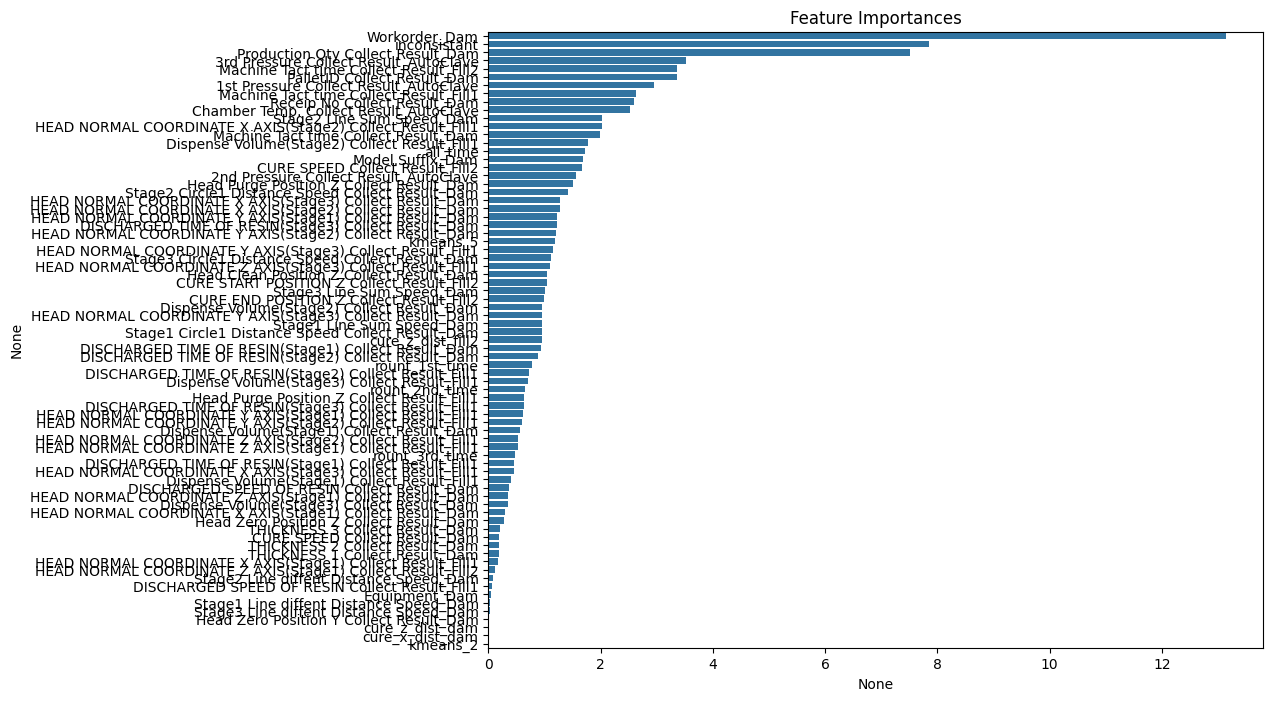

In [55]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(cat_best_model.feature_importances_, index=list(X_train_cat_last.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [56]:
# valid 확인하기
pred = cat_best_model.predict(X_valid_cat_last)
get_clf_eval(y_valid_cat_last, pred)

오차행렬:
 [[  33  425]
 [   0 7644]]

정확도: 0.9475
정밀도: 1.0000
재현율: 0.0721
F1: 0.1344


In [57]:
pred_cat_valid = cat_best_model.predict_proba(X_valid_cat_last)[:, 1]
pred_cat_valid

array([0.04725671, 0.05286083, 0.02875053, ..., 0.16155819, 0.12972549,
       0.03343947])

In [58]:
a = pd.DataFrame({'index': X_valid_cat_last.index, 'pred': pred_cat_valid})
a.to_csv('./data/catboost_valid_pred.csv', index = False)

In [59]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_cat, y_pred_custom_threshold_cat = model_best_threshold(cat_best_model, X_valid_cat_last, y_valid_cat_last)
get_clf_eval(y_valid_cat_last, y_pred_custom_threshold_cat)

오차행렬:
 [[  91  367]
 [ 267 7377]]

정확도: 0.9217
정밀도: 0.2542
재현율: 0.1987
F1: 0.2230


In [60]:
# tmp
proba1 = cat_best_model.predict_proba(X_cat)[:, 1]

#### LGBM

In [61]:
lgbm_best_params["random_state"] = 42  # LightGBM에서는 random_state를 사용합니다.
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_train_lgbm_last, y_train_lgbm_last, categorical_feature=cat_features_indices)

LGBMClassifier(colsample_bytree=0.3090112344603275,
               learning_rate=0.00981135431104963, max_depth=13,
               min_child_samples=28, min_child_weight=2.7642564263431395,
               n_estimators=1413, num_leaves=60, random_state=42,
               reg_alpha=0.019562669437349654, reg_lambda=0.001668169532371799,
               subsample=0.44589143331053394)

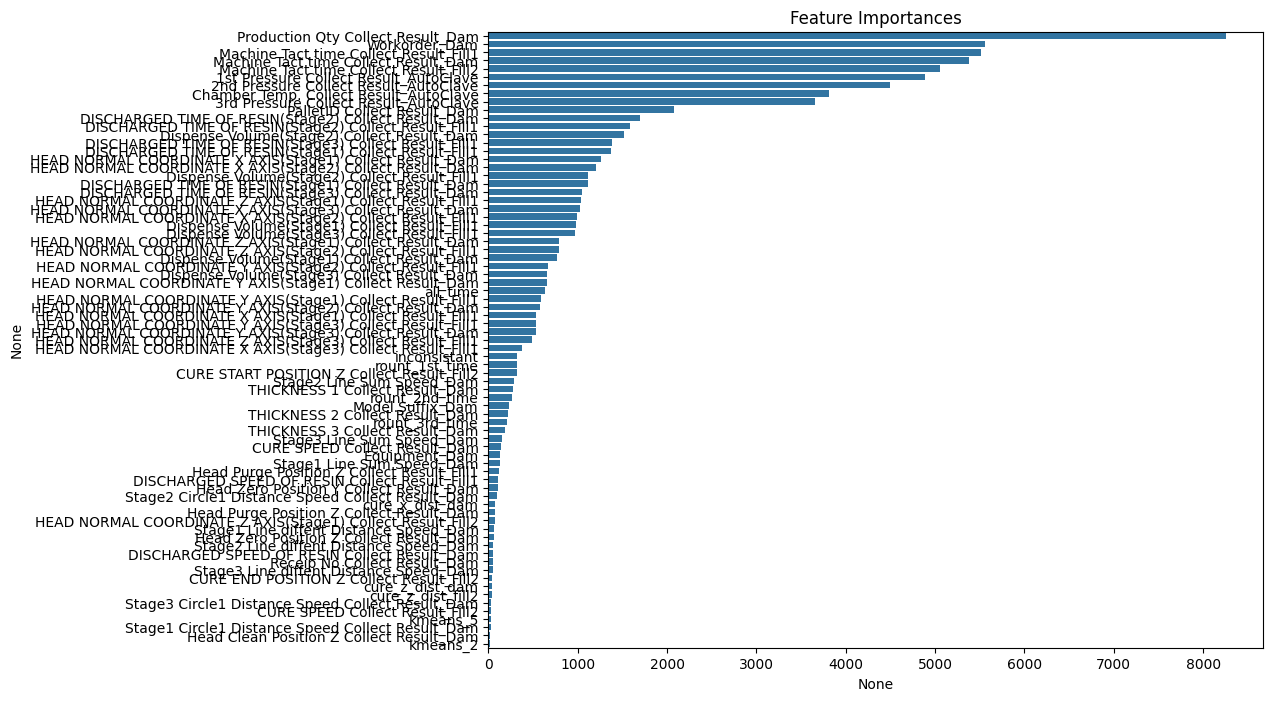

In [62]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(lgbm_best_model.feature_importances_, index=list(X_train_lgbm_last.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [63]:
pred = lgbm_best_model.predict(X_valid_lgbm_last)
get_clf_eval(y_valid_lgbm_last, pred)

오차행렬:
 [[  34  424]
 [   3 7641]]

정확도: 0.9473
정밀도: 0.9189
재현율: 0.0742
F1: 0.1374


In [64]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_lgbm, y_pred_custom_threshold_lgbm = model_best_threshold(lgbm_best_model, X_valid_lgbm_last, y_valid_lgbm_last)
get_clf_eval(y_valid_lgbm_last, y_pred_custom_threshold_lgbm)

오차행렬:
 [[ 109  349]
 [ 337 7307]]

정확도: 0.9153
정밀도: 0.2444
재현율: 0.2380
F1: 0.2412


In [65]:
proba2 = lgbm_best_model.predict_proba(X_lgbm)[:, 1]

#### XGB

In [66]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_state"] = 42
xgb_best_model = XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_train_xgb_last, y_train_xgb_last)

XGBClassifier(alpha=0.013910798126745097, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7329149706999373, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5145335736369887,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.003206939430527012,
              learning_rate=0.6564146733078825, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=439, n_jobs=None, ...)

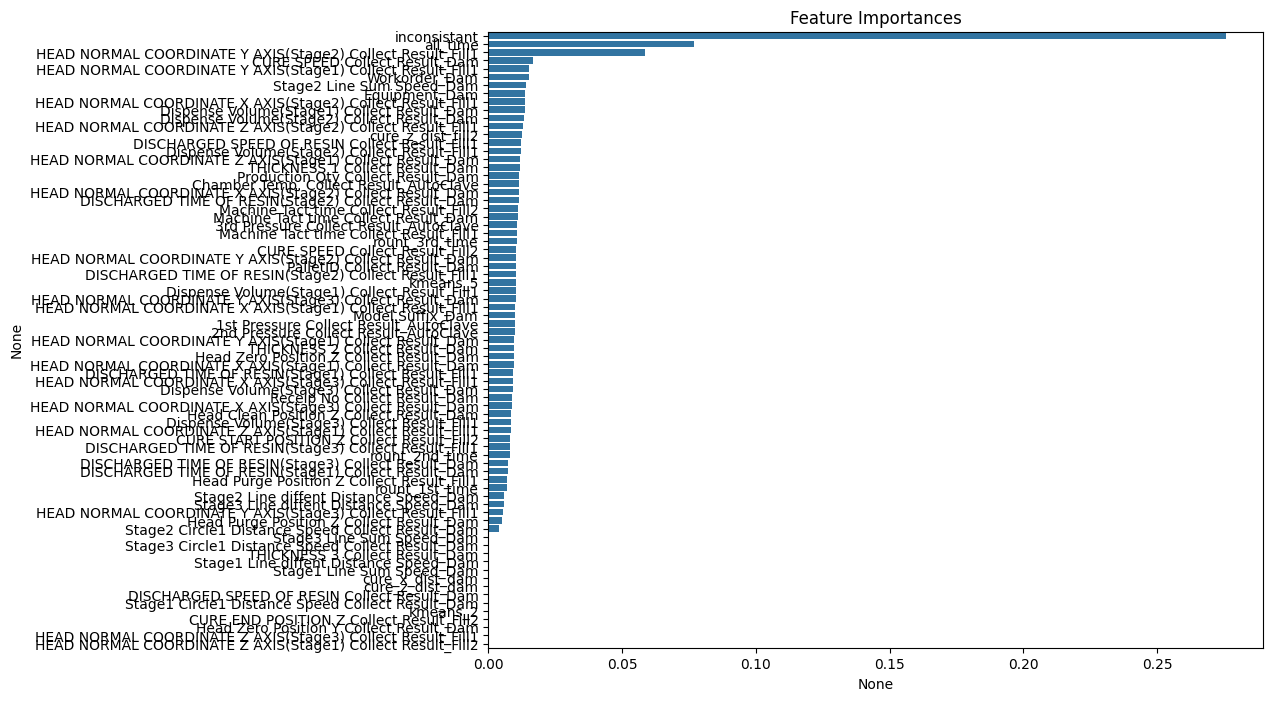

In [67]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(xgb_best_model.feature_importances_, index=list(X_train_xgb_last.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [68]:
pred = xgb_best_model.predict(X_valid_xgb_last)
get_clf_eval(y_valid_xgb_last, pred)

오차행렬:
 [[  43  415]
 [  81 7563]]

정확도: 0.9388
정밀도: 0.3468
재현율: 0.0939
F1: 0.1478


In [69]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_xgb, y_pred_custom_threshold_xgb = model_best_threshold(xgb_best_model, X_valid_xgb_last, y_valid_xgb_last)
get_clf_eval(y_valid_xgb_last, y_pred_custom_threshold_xgb)

오차행렬:
 [[  88  370]
 [ 414 7230]]

정확도: 0.9032
정밀도: 0.1753
재현율: 0.1921
F1: 0.1833


In [70]:
proba3 = xgb_best_model.predict_proba(X_xgb)[:, 1]

## 6. Inference

### Catboost

In [71]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_cat, y_cat, cat_features=cat_features_indices)

0:	learn: 0.6581453	total: 31.3ms	remaining: 25s
1:	learn: 0.6250428	total: 120ms	remaining: 48s
2:	learn: 0.5945562	total: 200ms	remaining: 53.1s
3:	learn: 0.5663841	total: 268ms	remaining: 53.4s
4:	learn: 0.5407516	total: 312ms	remaining: 49.6s
5:	learn: 0.5171154	total: 363ms	remaining: 48s
6:	learn: 0.4953776	total: 414ms	remaining: 46.9s
7:	learn: 0.4752473	total: 441ms	remaining: 43.7s
8:	learn: 0.4565623	total: 523ms	remaining: 46s
9:	learn: 0.4390887	total: 574ms	remaining: 45.4s
10:	learn: 0.4229432	total: 644ms	remaining: 46.2s
11:	learn: 0.4083163	total: 663ms	remaining: 43.5s
12:	learn: 0.3946509	total: 736ms	remaining: 44.6s
13:	learn: 0.3812856	total: 811ms	remaining: 45.5s
14:	learn: 0.3697557	total: 831ms	remaining: 43.5s
15:	learn: 0.3590658	total: 878ms	remaining: 43s
16:	learn: 0.3491707	total: 924ms	remaining: 42.6s
17:	learn: 0.3397109	total: 989ms	remaining: 43s
18:	learn: 0.3310711	total: 1.05s	remaining: 43.2s
19:	learn: 0.3232411	total: 1.07s	remaining: 41.7s
2

164:	learn: 0.2032152	total: 9.42s	remaining: 36.3s
165:	learn: 0.2031700	total: 9.51s	remaining: 36.3s
166:	learn: 0.2031496	total: 9.59s	remaining: 36.3s
167:	learn: 0.2031066	total: 9.66s	remaining: 36.3s
168:	learn: 0.2030919	total: 9.74s	remaining: 36.4s
169:	learn: 0.2030739	total: 9.78s	remaining: 36.3s
170:	learn: 0.2030511	total: 9.84s	remaining: 36.2s
171:	learn: 0.2030266	total: 9.91s	remaining: 36.2s
172:	learn: 0.2029857	total: 9.99s	remaining: 36.2s
173:	learn: 0.2029606	total: 10s	remaining: 36s
174:	learn: 0.2029528	total: 10s	remaining: 35.9s
175:	learn: 0.2029007	total: 10.1s	remaining: 35.9s
176:	learn: 0.2028740	total: 10.2s	remaining: 35.9s
177:	learn: 0.2028586	total: 10.3s	remaining: 35.8s
178:	learn: 0.2028549	total: 10.3s	remaining: 35.7s
179:	learn: 0.2028231	total: 10.4s	remaining: 35.7s
180:	learn: 0.2028197	total: 10.4s	remaining: 35.5s
181:	learn: 0.2027935	total: 10.5s	remaining: 35.5s
182:	learn: 0.2027391	total: 10.5s	remaining: 35.5s
183:	learn: 0.2027

324:	learn: 0.2001154	total: 19.2s	remaining: 28.1s
325:	learn: 0.2001105	total: 19.3s	remaining: 28s
326:	learn: 0.2000817	total: 19.4s	remaining: 28s
327:	learn: 0.2000676	total: 19.4s	remaining: 28s
328:	learn: 0.2000612	total: 19.5s	remaining: 27.9s
329:	learn: 0.2000264	total: 19.6s	remaining: 27.9s
330:	learn: 0.2000264	total: 19.6s	remaining: 27.8s
331:	learn: 0.2000246	total: 19.6s	remaining: 27.6s
332:	learn: 0.2000194	total: 19.7s	remaining: 27.6s
333:	learn: 0.1999977	total: 19.7s	remaining: 27.5s
334:	learn: 0.1999903	total: 19.8s	remaining: 27.4s
335:	learn: 0.1999790	total: 19.8s	remaining: 27.4s
336:	learn: 0.1999582	total: 19.9s	remaining: 27.4s
337:	learn: 0.1999336	total: 20s	remaining: 27.3s
338:	learn: 0.1999243	total: 20.1s	remaining: 27.3s
339:	learn: 0.1999179	total: 20.1s	remaining: 27.2s
340:	learn: 0.1999051	total: 20.1s	remaining: 27.1s
341:	learn: 0.1999051	total: 20.1s	remaining: 26.9s
342:	learn: 0.1999039	total: 20.2s	remaining: 26.9s
343:	learn: 0.199898

485:	learn: 0.1972854	total: 29.7s	remaining: 19.2s
486:	learn: 0.1972742	total: 29.8s	remaining: 19.1s
487:	learn: 0.1972581	total: 29.8s	remaining: 19.1s
488:	learn: 0.1972046	total: 29.9s	remaining: 19s
489:	learn: 0.1972040	total: 30s	remaining: 19s
490:	learn: 0.1972034	total: 30s	remaining: 18.9s
491:	learn: 0.1972027	total: 30.1s	remaining: 18.8s
492:	learn: 0.1971464	total: 30.2s	remaining: 18.8s
493:	learn: 0.1971451	total: 30.2s	remaining: 18.7s
494:	learn: 0.1971424	total: 30.3s	remaining: 18.7s
495:	learn: 0.1971158	total: 30.4s	remaining: 18.6s
496:	learn: 0.1971145	total: 30.4s	remaining: 18.6s
497:	learn: 0.1971139	total: 30.5s	remaining: 18.5s
498:	learn: 0.1970761	total: 30.6s	remaining: 18.5s
499:	learn: 0.1970679	total: 30.7s	remaining: 18.4s
500:	learn: 0.1970473	total: 30.7s	remaining: 18.3s
501:	learn: 0.1970467	total: 30.8s	remaining: 18.3s
502:	learn: 0.1970232	total: 30.9s	remaining: 18.2s
503:	learn: 0.1969994	total: 31s	remaining: 18.2s
504:	learn: 0.1969805	

644:	learn: 0.1943221	total: 41.8s	remaining: 10s
645:	learn: 0.1943213	total: 41.8s	remaining: 9.97s
646:	learn: 0.1943187	total: 41.9s	remaining: 9.91s
647:	learn: 0.1942976	total: 42s	remaining: 9.85s
648:	learn: 0.1942651	total: 42.1s	remaining: 9.79s
649:	learn: 0.1942531	total: 42.1s	remaining: 9.72s
650:	learn: 0.1942277	total: 42.2s	remaining: 9.66s
651:	learn: 0.1942118	total: 42.3s	remaining: 9.6s
652:	learn: 0.1942108	total: 42.3s	remaining: 9.53s
653:	learn: 0.1941710	total: 42.4s	remaining: 9.47s
654:	learn: 0.1941703	total: 42.5s	remaining: 9.4s
655:	learn: 0.1941363	total: 42.6s	remaining: 9.34s
656:	learn: 0.1940899	total: 42.6s	remaining: 9.28s
657:	learn: 0.1940672	total: 42.7s	remaining: 9.22s
658:	learn: 0.1939862	total: 42.8s	remaining: 9.15s
659:	learn: 0.1939289	total: 42.9s	remaining: 9.09s
660:	learn: 0.1939246	total: 42.9s	remaining: 9.03s
661:	learn: 0.1939139	total: 43s	remaining: 8.96s
662:	learn: 0.1938684	total: 43.1s	remaining: 8.9s
663:	learn: 0.1938670

In [72]:
# pred
cat_pred = cat_best_model.predict(X_test_cat)

In [73]:
np.unique(cat_pred, return_counts = True)

(array([0, 1]), array([17285,    76]))

### LGBM

In [74]:
# 최적의 하이퍼파라미터로 모델 재학습
lgbm_best_params["random_seed"] = 42
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_lgbm, y_lgbm, categorical_feature=cat_features_indices)

LGBMClassifier(colsample_bytree=0.3090112344603275,
               learning_rate=0.00981135431104963, max_depth=13,
               min_child_samples=28, min_child_weight=2.7642564263431395,
               n_estimators=1413, num_leaves=60, random_seed=42,
               random_state=42, reg_alpha=0.019562669437349654,
               reg_lambda=0.001668169532371799, subsample=0.44589143331053394)

In [75]:
# pred
lgbm_pred = lgbm_best_model.predict(X_test_lgbm)

In [76]:
np.unique(lgbm_pred, return_counts = True)

(array([0, 1]), array([17276,    85]))

### XGB

In [77]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_seed"] = 42
xgb_best_model = XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_xgb, y_xgb)

/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:58:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.013910798126745097, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7329149706999373, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5145335736369887,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.003206939430527012,
              learning_rate=0.6564146733078825, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=439, n_jobs=None, ...)

In [78]:
# pred
xgb_pred = xgb_best_model.predict(X_test_xgb)

In [79]:
np.unique(xgb_pred, return_counts = True)

(array([0, 1]), array([17052,   309]))

In [80]:
# best ensemble
best_f1 = 0
best_f1_t = 0
best_weights = None
best_weights_t = None

# 가중치 조합 테스트
for w1 in range(1, 10):
    for w2 in range(0, 10):
        for w3 in range(0, 10):
                # 가중 평균 계산
                final_proba = (w1 * proba1 + w2 * proba2 + w3 * proba3) / (w1 + w2 + w3)
                y_pred = (final_proba > 0.5).astype(int)
            
                # F1 스코어 계산
                f1 = f1_score(df_train['target'], y_pred)
                print(f1)
                
                # Threshold 스코어 계산
                precision, recall, thresholds = precision_recall_curve(df_train['target'], final_proba)
                f1_scores = 2*recall*precision / (recall + precision)
                best_threshold = thresholds[np.argmax(f1_scores)]
                y_pred_custom_threshold = (final_proba >= best_threshold).astype(int)
                f1_t = f1_score(df_train['target'], y_pred_custom_threshold)

                # 최고 성능 저장
                if f1 > best_f1:
                    best_f1 = f1
                    best_weights = (w1, w2, w3)
                
                if f1_t > best_f1_t:
                    best_f1_t = f1_t
                    best_weights_t = (w1, w2, w3)

print("Best F1 Score: ", best_f1)
print("Best Weights: ", best_weights)

0.15444923559388474
0.20872865275142316
0.3196894848270996
0.35173123071648954
0.3736115785930663
0.3868175765645805
0.3976300197498355
0.40445026178010474
0.4076973255055447
0.4096228868660598
0.16880591209646054
0.2119255601974933
0.2829090909090909
0.3239038189533239
0.35196687370600416
0.36827773995915586
0.38034331874789634
0.3897058823529412
0.3953565505804311
0.3990749917409977
0.18713900654601462
0.2207939508506616
0.2635259477364741
0.3074166965245432
0.3294532627865961
0.3548163548163548
0.36382322713257964
0.37474541751527496
0.3843823628407943
0.38821954484605087
0.20503048780487806
0.23149192033070276
0.25942350332594233
0.29284164859002165
0.3151515151515151
0.3329813445969729
0.3544918487686438
0.3621342512908778
0.3710777626193724
0.37859803589569924
0.2145564821834723
0.2348087021755439
0.26080531954192837
0.2864412940748819
0.3043790380473797
0.32113676731793955
0.33719704952581664
0.3510601320820299
0.363761625904237
0.36737491432488006
0.22264150943396224
0.24065769

0.2478664192949907
0.27003293084522506
0.28736880202678244
0.16601714731098988
0.1675107128944293
0.17603722373012798
0.1837837837837838
0.19208605455243952
0.20836501901140683
0.22897897897897898
0.24656516895655403
0.260132645541636
0.28519593613933236
0.1673803036200856
0.17178390983287992
0.17956656346749228
0.18658442559753277
0.19547719432732846
0.21184510250569472
0.22981599699586933
0.2427401340282948
0.25820730357801547
0.2741228070175438
0.16880591209646054
0.1774506005424254
0.1837837837837838
0.1907692307692308
0.19961759082217975
0.2119255601974933
0.2286573899962392
0.24479166666666674
0.25830258302583026
0.26460859977949286
0.1702954898911353
0.1802707930367505
0.18588507520246816
0.19485999232834675
0.20450209843571154
0.21328273244781787
0.22998872604284099
0.24627976190476186
0.2570162481536189
0.2621502209131075
0.17738187451587914
0.18308227114716108
0.1893035782993459
0.1990049751243781
0.20655487804878048
0.21396054628224584
0.2280767783214151
0.24319283849309958


0.19678407350689125
0.20760456273764258
0.16601714731098988
0.16679657053780206
0.1675107128944293
0.17249417249417248
0.17815646785437647
0.1823802163833076
0.18651252408477842
0.19000000000000003
0.1975497702909648
0.20904599011782593
0.16601714731098988
0.1675107128944293
0.16964980544747085
0.17532971295577968
0.17886178861788615
0.1837837837837838
0.1893035782993459
0.19278033794162824
0.1976254308693987
0.21116597037599696
0.1673803036200856
0.16893732970027248
0.17107309486780714
0.17603722373012798
0.1802707930367505
0.18588507520246816
0.19007310504040015
0.19416730621642364
0.2003058103975535
0.21184510250569472
0.1673803036200856
0.16964980544747085
0.17462165308498254
0.17886178861788615
0.1837837837837838
0.18728323699421964
0.1914648212226067
0.1961685823754789
0.2023673157693776
0.21116597037599696
0.16880591209646054
0.17107309486780714
0.17815646785437647
0.1802707930367505
0.18588507520246816
0.18728323699421964
0.19347408829174664
0.1990049751243781
0.203739030904235

In [91]:
best_f1_t

0.677376171352075

In [92]:
best_weights_t

(1, 9, 3)

In [120]:
# best ensemble 적용
cat = proba1 * 1
lgbm = proba2 * 9
xgb = proba3 * 3
y_best = (cat + lgbm + xgb)/(1 + 9 + 3)

In [121]:
precision, recall, thresholds = precision_recall_curve(df_train['target'], y_best)
f1_scores = 2*recall*precision / (recall + precision)
weights_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_best >= weights_best_threshold).astype(int)
get_clf_eval(df_train['target'], y_pred_custom_threshold)

오차행렬:
 [[ 1518   832]
 [  614 37542]]

정확도: 0.9643
정밀도: 0.7120
재현율: 0.6460
F1: 0.6774


In [122]:
# proba
xgb_proba = xgb_best_model.predict_proba(X_test_xgb)[:, 1]
cat_proba = cat_best_model.predict_proba(X_test_cat)[:, 1]
lgbm_proba = lgbm_best_model.predict_proba(X_test_lgbm)[:, 1]

In [123]:
# 추론
cat = cat_proba * 1
lgbm = lgbm_proba * 9
xgb = xgb_proba * 3
p = (cat + lgbm + xgb)/(1 + 9 + 3)

In [124]:
p2 = np.where(p >= weights_best_threshold, 'AbNormal', 'Normal')

In [125]:
np.unique(p2, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([  720, 16641]))

In [126]:
p3 = np.where(cat_proba >= 0.5, 'AbNormal', 'Normal')

In [127]:
np.unique(p3, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([   76, 17285]))

## 7. Submission

In [128]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = p2

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [129]:
df_sub['target']

0        Normal
1        Normal
2        Normal
3        Normal
4        Normal
          ...  
17356    Normal
17357    Normal
17358    Normal
17359    Normal
17360    Normal
Name: target, Length: 17361, dtype: object

# 꼭 df_sub['target'] 확인하고 제출하시오